In [1]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


## Load and Manipulate Data

### Load the data

In [14]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./zcta-history/2020-04-01.csv', dtype = 'str')

cases_nyc_0407 = pd.read_csv('./zcta-history/2020-04-07.csv', dtype = 'str')
cases_nyc_0414 = pd.read_csv('./zcta-history/2020-04-14.csv', dtype = 'str')
cases_nyc_0421 = pd.read_csv('./zcta-history/2020-04-21.csv', dtype = 'str')
cases_nyc_0428 = pd.read_csv('./zcta-history/2020-04-28.csv', dtype = 'str')

### Combine and Manipulate the data

In [16]:
cases_nyc = cases_nyc.rename(columns={"Positive": "Positive_0401", "Total": "Total_0401", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0401"})

cases_nyc_0407 = cases_nyc_0407.rename(columns={"Positive": "Positive_0407", "Total": "Total_0407", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0407"})

cases_nyc_0414 = cases_nyc_0414.rename(columns={"Positive": "Positive_0414", "Total": "Total_0414", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0414"})

cases_nyc_0421 = cases_nyc_0421.rename(columns={"Positive": "Positive_0421", "Total": "Total_0421", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0421"})

cases_nyc_0428 = cases_nyc_0428.rename(columns={"Positive": "Positive_0428", "Total": "Total_0428", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0428"})

In [17]:
#Join together all the weekly cases data
cases_nyc = cases_nyc.merge(cases_nyc_0407, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0414, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0421, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
cases_nyc = cases_nyc.merge(cases_nyc_0428, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')

In [18]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [19]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [20]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)
        
#Divide by 100 for percents
# data.loc[:,"zcta_cum_perc_pos_0401"] = data.loc[:,"zcta_cum_perc_pos_0401"]/100.0
data.loc[:,"zcta_cum_perc_pos_0407"] = data.loc[:,"zcta_cum_perc_pos_0407"]/100.0
data.loc[:,"zcta_cum_perc_pos_0414"] = data.loc[:,"zcta_cum_perc_pos_0414"]/100.0
data.loc[:,"zcta_cum_perc_pos_0421"] = data.loc[:,"zcta_cum_perc_pos_0421"]/100.0
data.loc[:,"zcta_cum_perc_pos_0428"] = data.loc[:,"zcta_cum_perc_pos_0428"]/100.0


In [21]:
data.head()

,MODZCTA,Positive_0401,Total_0401,Positive_0407,Total_0407,zcta_cum_perc_pos_0407,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,113.0,265.0,170.0,364.0,0.4670,231.0,480.0,0.4812,266.0,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,250.0,542.0,405.0,792.0,0.5114,578.0,1094.0,0.5283,729.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,161.0,379.0,230.0,543.0,0.4236,290.0,692.0,0.4191,355.0,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,16.0,38.0,20.0,45.0,0.4444,23.0,59.0,0.3898,26.0,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,25.0,81.0,32.0,103.0,0.3107,40.0,122.0,0.3279,44.0,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0


### Handle Null Values

In [22]:
#Null values
data.isnull().sum(axis = 0).sort_values().tail(10)

med_monthlyhousingcost               3
med_numberrooms                      6
med_yearbuilt                        7
perc_hadbaby_pastyear_married        7
perc_hadbaby_pastyear_unmarried      7
med_value                           26
avg_hoursworked                     33
med_contractrent                    58
avg_income_deficit_pastyear        129
med_age_marriage                   177
dtype: int64

In [23]:
data[data.med_monthlyhousingcost.isnull()]

,MODZCTA,Positive_0401,Total_0401,Positive_0407,Total_0407,zcta_cum_perc_pos_0407,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
2,10002,250.0,542.0,405.0,792.0,0.5114,578.0,1094.0,0.5283,729.0,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
148,11377,364.0,628.0,736.0,1141.0,0.6450,1214.0,1845.0,0.6580,1448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
167,11428,112.0,171.0,241.0,355.0,0.6789,382.0,597.0,0.6399,489.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


None of the columns with very common nulls seem too critical. We will exclude the columns with more than 10 nulls and for those with less than 10 nulls we will impute the value using the average.

In [24]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [25]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

In [26]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

pop_perc_some_college          0
pop_perc_hs                    0
pop_perc_under_hs              0
perc_transport_to_work_walk    0
beds                           0
dtype: int64

In [27]:
#Percent Columns
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1

## Standardize the data

### Standardize the SES Covariates

In [28]:
#Exclude outcome variables
X = data.loc[:,"median_house_income":]

In [32]:
#Exclude a few covariates we decided against
X = X.drop(['perc_leave_for_work_12ato459',
       'perc_leave_for_work_5to529', 'perc_leave_for_work_530to559',
       'perc_leave_for_work_6to629', 'perc_leave_for_work_630to659',
       'perc_leave_for_work_7to729', 'perc_leave_for_work_730to759',
       'perc_leave_for_work_8to829', 'perc_leave_for_work_830to859',
       'perc_leave_for_work_9to959', 'perc_leave_for_work_10to1059',
       'perc_leave_for_work_11to1159', 'perc_leave_for_work_12pto359',
       'perc_leave_for_work_4pto1159'], axis = 1)

In [34]:
#Set the scaler
X = preprocessing.StandardScaler().fit_transform(X)

### Standardize the outcome variable (disease burden)

First, we calculate the continuous cases per capita.

In [35]:
data

,MODZCTA,Positive_0401,Total_0401,Positive_0407,Total_0407,zcta_cum_perc_pos_0407,Positive_0414,Total_0414,zcta_cum_perc_pos_0414,Positive_0421,...,perc_transportation_warehousing,perc_utilites,perc_information,perc_finance,perc_scientific,perc_education_healthcare,perc_arts_entertainment,perc_otherservices,perc_publicadministration,beds
1,10001,113.0,265.0,170.0,364.0,0.4670,231.0,480.0,0.4812,266.0,...,0.060729,0.005398,0.018893,0.020243,0.037787,0.191633,0.017544,0.018893,0.045884,0.0
2,10002,250.0,542.0,405.0,792.0,0.5114,578.0,1094.0,0.5283,729.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0
3,10003,161.0,379.0,230.0,543.0,0.4236,290.0,692.0,0.4191,355.0,...,0.050100,0.008016,0.022044,0.040080,0.088176,0.126253,0.036072,0.026052,0.052104,501.0
4,10004,16.0,38.0,20.0,45.0,0.4444,23.0,59.0,0.3898,26.0,...,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.0
5,10005,25.0,81.0,32.0,103.0,0.3107,40.0,122.0,0.3279,44.0,...,0.050412,0.004583,0.018332,0.032997,0.035747,0.156737,0.096242,0.039413,0.048579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,11691,436.0,694.0,822.0,1226.0,0.6705,1215.0,1792.0,0.6780,1543.0,...,0.067224,0.010110,0.006391,0.089942,0.087212,0.232642,0.041659,0.031550,0.059497,166.0
174,11692,110.0,184.0,214.0,332.0,0.6446,332.0,521.0,0.6372,399.0,...,0.047733,0.004714,0.022434,0.097375,0.113962,0.218138,0.036874,0.028819,0.020227,0.0
175,11693,86.0,144.0,147.0,242.0,0.6074,220.0,369.0,0.5962,262.0,...,0.042344,0.004185,0.003939,0.073855,0.097489,0.177991,0.046775,0.084934,0.032004,0.0
176,11694,143.0,270.0,267.0,457.0,0.5842,384.0,662.0,0.5801,475.0,...,0.065959,0.014914,0.014914,0.091021,0.050123,0.208948,0.056888,0.035055,0.067189,0.0


In [59]:
#Number of cases per capita - continuous
cases_per_10k = data[["Positive_0401","Positive_0407","Positive_0414","Positive_0421","Positive_0428","pop_total"]]

cases_per_10k.loc[:,"cases_per_10k_0401"] = 10000 * cases_per_10k.loc[:,"Positive_0401"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0407"] = 10000 * cases_per_10k.loc[:,"Positive_0407"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0414"] = 10000 * cases_per_10k.loc[:,"Positive_0414"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0421"] = 10000 * cases_per_10k.loc[:,"Positive_0421"] / \
    cases_per_10k.loc[:,"pop_total"]
cases_per_10k.loc[:,"cases_per_10k_0428"] = 10000 * cases_per_10k.loc[:,"Positive_0428"] / \
    cases_per_10k.loc[:,"pop_total"]

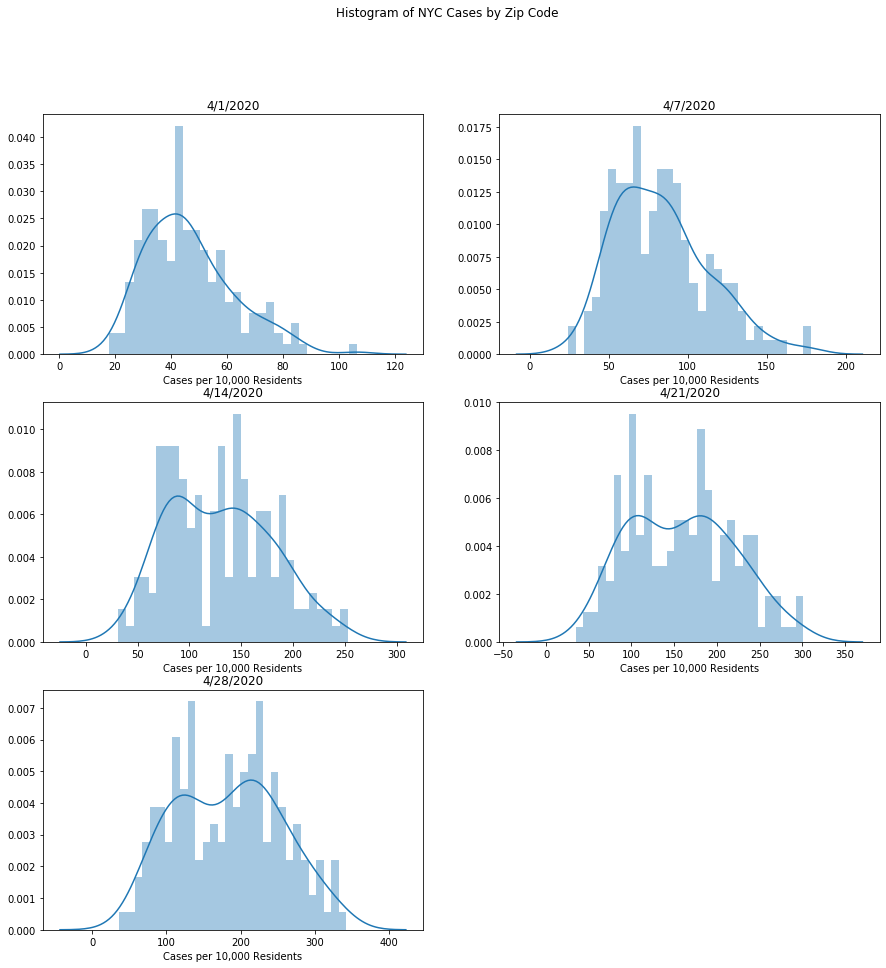

In [63]:
#Visualize the distribution of cases by zip
plt.figure(figsize = (15,15))
plt.suptitle("Histogram of NYC Cases by Zip Code")

plt.subplot(3,2,1)
sns.distplot(cases_per_10k.cases_per_10k_0401, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/1/2020")

plt.subplot(3,2,2)
sns.distplot(cases_per_10k.cases_per_10k_0407, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/7/2020")

plt.subplot(3,2,3)
sns.distplot(cases_per_10k.cases_per_10k_0414, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/14/2020")

plt.subplot(3,2,4)
sns.distplot(cases_per_10k.cases_per_10k_0421, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/21/2020")

plt.subplot(3,2,5)
sns.distplot(cases_per_10k.cases_per_10k_0428, bins = 30)
plt.xlabel("Cases per 10,000 Residents")
plt.title("4/28/2020")

plt.show();

We observe a distinct bimodal distribution. Notably, the modes spread farther apart over time. 

For 4/7/2020, our target date, we calculate the categories of cases per capita for the outcome variable for classifiers. We note from the distribution above that the "high" vs "low" risk area appears to occur around 75 cases per 10,000 residents.

In [66]:
y_categorical_0407 = np.zeros(len(cases_per_10k.cases_per_10k_0407))
y_categorical_0407 = y_categorical_0407.astype(str)

#Low
y_categorical_0407[cases_per_10k.cases_per_10k_0407 <= 75] = "Low"
#High
y_categorical_0407[cases_per_10k.cases_per_10k_0407 > 75] = "High"

pd.DataFrame(y_categorical_0407, columns = ['y']).groupby('y').size()

y
High    99
Low     78
dtype: int64

## Clustering Analysis

### PCA and Preliminary Cluster Visualization

The bimodal distribution certainly seems to indicate that not all of these cases are coming from the same distribution and there are underlying factors that are differentiating these observations.

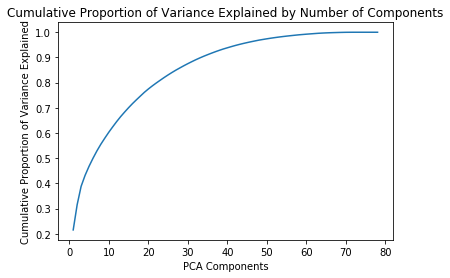

In [52]:
#Fit PCA
pca = PCA().fit(X)
X_pca = PCA().fit_transform(X)

#Plot Variance explained
plt.plot(list(range(1,79)), np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Proportion of Variance Explained by Number of Components")
plt.xlabel("PCA Components")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.show();

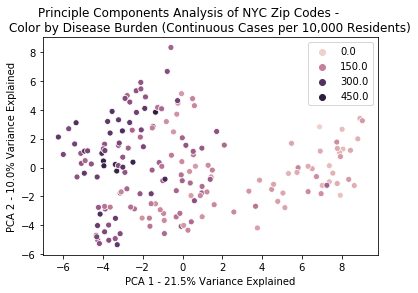

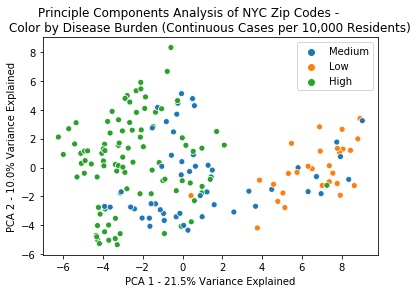

In [53]:
#Plot continuous
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = cases_per_10k)
plt.title("Principle Components Analysis of NYC Zip Codes - \
          \nColor by Disease Burden (Continuous Cases per 10,000 Residents)")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.show();

#Plot Categorical
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = y_categorical)
plt.title("Principle Components Analysis of NYC Zip Codes - \
          \nColor by Disease Burden (Continuous Cases per 10,000 Residents)")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")
plt.show();

Even when looking just at the first two Principle Components, we can see clear clusters forming. These align quite clearly with the disease burden categories that we have identified.

### K Means - Raw Data

In [54]:
kmeans_fit_2 = KMeans(n_clusters = 2, n_init = 1, init = 'k-means++', random_state = 0).fit(X)
kmeans_fit_3 = KMeans(n_clusters = 3, n_init = 1, init = 'k-means++', random_state = 0).fit(X)

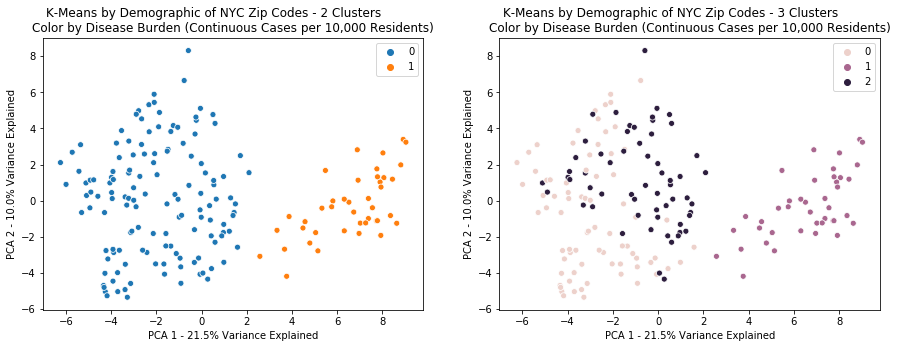

In [55]:
#Plot K Means
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_2.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by Disease Burden (Continuous Cases per 10,000 Residents)")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(1,2,2)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_3.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by Disease Burden (Continuous Cases per 10,000 Residents)")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.show();

In [56]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(5,5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette analysis for KMeans clustering on sample data")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


For n_clusters = 2, the average silhouette_score is 0.1946043629919285.


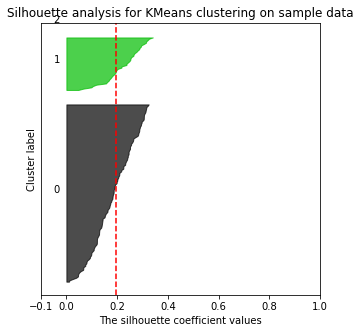

In [57]:
silplot(X, kmeans_fit_2.labels_, kmeans_fit_2, pointlabels=None)

For n_clusters = 3, the average silhouette_score is 0.09502482791899002.


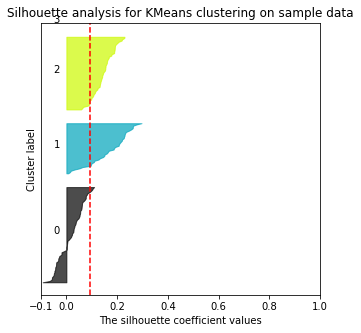

In [58]:
silplot(X, kmeans_fit_3.labels_, kmeans_fit_3, pointlabels=None)

The silhouette for n = 2 looks significantly better than the silhouette for n = 3. The average silhouette score is 0.195 vs 0.095.

### K Means - After PCA

In [59]:
kmeans_fit_2_PCA = KMeans(n_clusters = 2, n_init = 1, init = 'k-means++', random_state = 0).fit(X_pca[:,:50])
kmeans_fit_3_PCA = KMeans(n_clusters = 3, n_init = 1, init = 'k-means++', random_state = 0).fit(X_pca[:,:50])

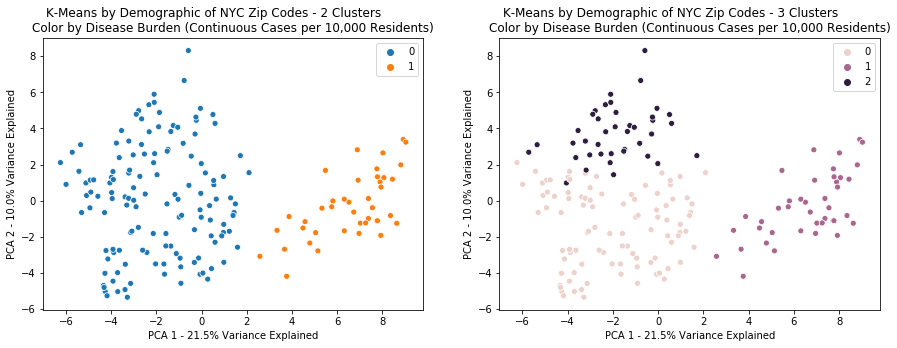

In [60]:
#Plot K Means
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_2_PCA.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 2 Clusters\
          \nColor by Disease Burden (Continuous Cases per 10,000 Residents)")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.subplot(1,2,2)
sns.scatterplot(X_pca[:,0],X_pca[:,1], hue = kmeans_fit_3_PCA.labels_)
plt.title("K-Means by Demographic of NYC Zip Codes - 3 Clusters\
          \nColor by Disease Burden (Continuous Cases per 10,000 Residents)")
plt.xlabel("PCA 1 - " + str(round(pca.explained_variance_ratio_[0] * 100,1)) + "% Variance Explained")
plt.ylabel("PCA 2 - " + str(round(pca.explained_variance_ratio_[1] * 100,1)) + "% Variance Explained")

plt.show();

For n_clusters = 2, the average silhouette_score is 0.1946043629919285.


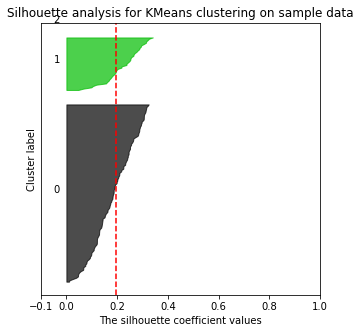

In [61]:
silplot(X, kmeans_fit_2_PCA.labels_, kmeans_fit_2_PCA, pointlabels=None)

For n_clusters = 3, the average silhouette_score is 0.12506813433442676.


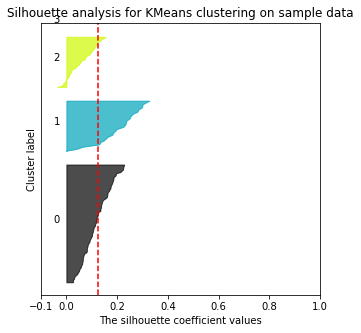

In [62]:
silplot(X, kmeans_fit_3_PCA.labels_, kmeans_fit_3_PCA, pointlabels=None)

Removing outliers through PCA has the result of discerning the cluster in the upper left hand side slightly better when n_clusters = 3, although the silhouette score is still lower for those categories compared to n_clusters = 2.

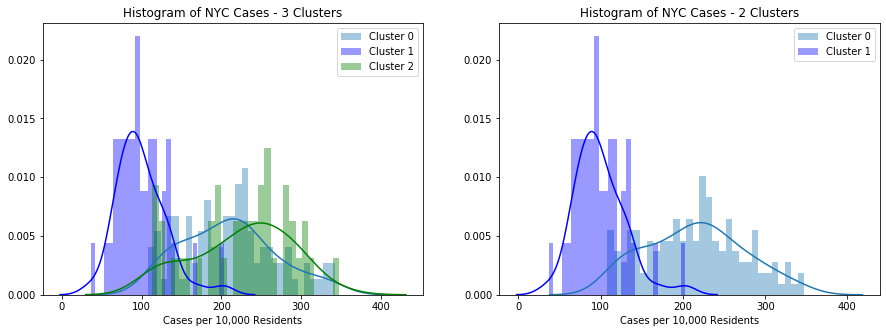

In [63]:
#Plot the histogram with the clusters
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
sns.distplot(cases_per_10k[kmeans_fit_3_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k[kmeans_fit_3_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
sns.distplot(cases_per_10k[kmeans_fit_3_PCA.labels_ == 2], bins = 30, color = 'green', label = 'Cluster 2')
plt.title("Histogram of NYC Cases as of 4/30 - 3 Clusters")
plt.xlabel("Cases per 10,000 Residents")
plt.legend()

plt.subplot(1,2,2)
sns.distplot(cases_per_10k[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.title("Histogram of NYC Cases as of 4/30 - 2 Clusters")
plt.xlabel("Cases per 10,000 Residents")
plt.legend()

plt.show();

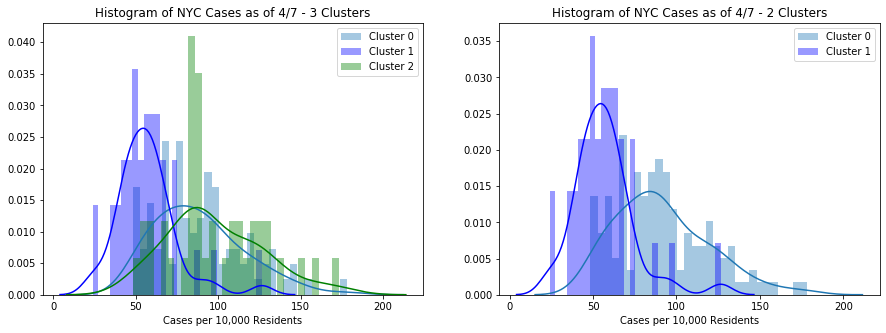

In [64]:
#Plot the histogram with the clusters
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
sns.distplot(cases_per_10k_0407[kmeans_fit_3_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k_0407[kmeans_fit_3_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
sns.distplot(cases_per_10k_0407[kmeans_fit_3_PCA.labels_ == 2], bins = 30, color = 'green', label = 'Cluster 2')
plt.title("Histogram of NYC Cases as of 4/7 - 3 Clusters")
plt.xlabel("Cases per 10,000 Residents")
plt.legend()

plt.subplot(1,2,2)
sns.distplot(cases_per_10k_0407[kmeans_fit_2_PCA.labels_ == 0], bins = 30, label = 'Cluster 0')
sns.distplot(cases_per_10k_0407[kmeans_fit_2_PCA.labels_ == 1], bins = 30, color = 'blue', label = 'Cluster 1')
plt.title("Histogram of NYC Cases as of 4/7 - 2 Clusters")
plt.xlabel("Cases per 10,000 Residents")
plt.legend()

plt.show();

In [78]:
y_categorical_2_01 = np.zeros(len(y_categorical_2))
y_categorical_2_01[y_categorical_2 == "High"] = 1
y_categorical_2_01

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [86]:
rf = RandomForestClassifier(n_estimators = 200, oob_score = True).fit(X, y_categorical_2_01)

In [87]:
rf.oob_score_

0.8361581920903954

In [88]:
help(data.drop)

Help on method drop in module pandas.core.frame:

drop(labels=None, axis=0, index=None, columns=None, level=None, inplace=False, errors='raise') method of pandas.core.frame.DataFrame instance
    Drop specified labels from rows or columns.
    
    Remove rows or columns by specifying label names and corresponding
    axis, or by specifying directly index or column names. When using a
    multi-index, labels on different levels can be removed by specifying
    the level.
    
    Parameters
    ----------
    labels : single label or list-like
        Index or column labels to drop.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Whether to drop labels from the index (0 or 'index') or
        columns (1 or 'columns').
    index : single label or list-like
        Alternative to specifying axis (``labels, axis=0``
        is equivalent to ``index=labels``).
    
        .. versionadded:: 0.21.0
    columns : single label or list-like
        Alternative to specifying axis (